In [34]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
np.set_printoptions(precision=6)

In [35]:
dataset = "../../../link_bot_teleop/data/random_speeds.txt"
goal = np.zeros((6,1))
data = tpo.load_train(dataset, n_steps=1, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))

speed 1.2179024212922607
distance error for xy model 0.34713527005830747
distance error for no dynamics model 0.27511727976585754
:'(


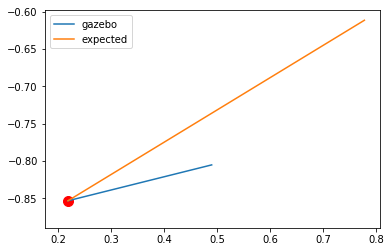

In [39]:
example_idx = 4
traj = data[:, :, example_idx]
vx = traj[0][6]
vy = traj[0][7]
s = traj[0][[0, 1]]
s_true = traj[1][[0, 1]]
s_expected = s + np.array([vx, vy]) * 0.5
d_true = s_true - s
d_expected = s_expected - s
xy_error = s_true - s_expected
no_dynamics_error = s_true - s
xy_error_d = np.linalg.norm(xy_error)
no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
print('speed', np.hypot(vx, vy))
print('distance error for xy model', xy_error_d)
print('distance error for no dynamics model', no_dynamics_error_d)
if xy_error_d > no_dynamics_error_d:
    print(":'(")
plt.scatter(s[0], s[1], s=100, c='r')
plt.plot([s[0], s_true[0]], [s[1], s_true[1]], label='gazebo')
plt.plot([s[0], s_expected[0]], [s[1], s_expected[1]], label='expected')
plt.legend();

In [40]:
f = 0.0
m = 0
xy_error_sum = 0
no_dynamics_error_sum = 0
for i in range(data.shape[2]):
    traj = data[:, :, i]
    vx = traj[0][6]
    vy = traj[0][7]
    s = traj[0][[0, 1]]
    s_true = traj[1][[0, 1]]
    s_expected = s + np.array([vx, vy]) * 0.5
    d_true = s_true - s
    d_expected = s_expected - s
    xy_error = s_true - s_expected
    no_dynamics_error = s_true - s
    xy_error_d = np.linalg.norm(xy_error)
    no_dynamics_error_d = np.linalg.norm(no_dynamics_error)
    xy_error_sum += xy_error_d
    no_dynamics_error_sum += no_dynamics_error_d
    if xy_error_d > no_dynamics_error_d:
        f+=1
        s=np.hypot(vx, vy)
        if s > m:
            m = s
#         print("NO DYNAMICS MODEL DOES BETTER for example ", i)
#         print('\tspeed', np.hypot(vx, vy))
#         print('\tdistance error for xy model', xy_error_d)
#         print('\tdistance error for no dynamics model', no_dynamics_error_d)
#         plt.scatter(s[0], s[1], s=100, c='r')
#         plt.plot([s[0], s_true[0]], [s[1], s_true[1]], label='gazebo')
#         plt.plot([s[0], s_expected[0]], [s[1], s_expected[1]], label='expected')
#         plt.legend();
print(xy_error_sum/ data.shape[2])
print(no_dynamics_error_sum/ data.shape[2])
# print(m)
# print(f/data.shape[2])

0.32276954933595164
0.09035684144742116
